## Deep Learning: Natural Language Processing with Disaster Tweets

### Section 1: Problem Description & Data Summary
### Problem description
The goal of this project is to build a machine learning model that can predict whether a given tweet refers to a real disaster or does not refer to a real disaster. The data comes from the "Natural Language Processing with Disaster Tweets" dataset from the Kaggle competition. The project serves as a good intro to Natural Language Processing, NLP, involving analyzing and understanding language. In regards to the real world applicability, being able to find and identify messages from social media related to emergencies is extremely important and may save a lot of lives. 

### Data Summary
The dataset comes from Kaggle's competiiton dataset and contains a total of 10,929 tweets of data split into two different files, a train dataset and a test dataset. Each tweet is in a single roow along with other features. The main columns are the text column which contains the raw tweet and the target column which is a binary variable identifying whether the disaster in the tweet was real or not.  

### Codebook
| Column Name | Description                                                                                                                     |
| ----------- | ------------------------------------------------------------------------------------------------------------------------------- |
| `id`        | Unique identifier                                                                                     |
| `keyword`   | A disaster-related keyword from the tweet                                                        |
| `location`  | The location associated with the tweet                                                                        |
| `text`      | The content of the tweet                                  |
| `target`    | Binary target variable:`1` = real disaster, `0` = false disaster |


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

df = pd.read_csv('train.csv')

### Section 2: EDA

In [2]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
print("Missing values:\n", df.isnull().sum())

Missing values:
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


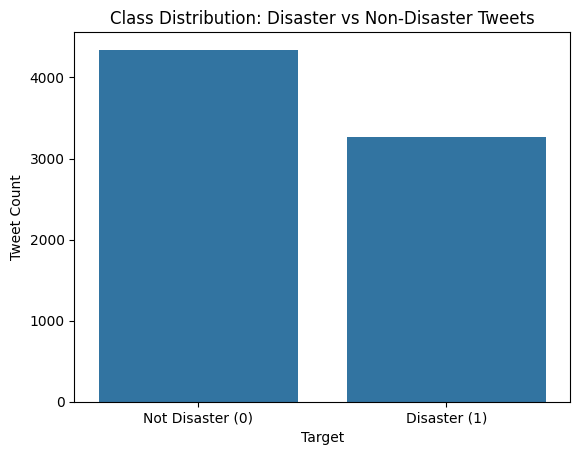

In [4]:
sns.countplot(data=df, x='target')
plt.title("Class Distribution: Disaster vs Non-Disaster Tweets")
plt.xlabel("Target")
plt.ylabel("Tweet Count")
plt.xticks([0, 1], ['Not Disaster (0)', 'Disaster (1)'])
plt.show()

In [5]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

df['clean_text'] = df['text'].apply(clean_text)

### Section 3: Data Architecture
To solve the project's goal, I implemented two different models: a TF-IDF vectorization with Logistic Regression model to serve as a baseline model similarily to how it was implemented a previous project. The second model was a more advanced sequential neural network that used a Long Short Term Memory architecture (LSTM). The idea is to be able to test out how different models would perform in this scenario. For the deep learning model, word toenization, padding, and an ebedded layer were used, implemented by the tensorflow library. Only a single LSTM layer with a small amount of units was used in order to keep the model simple and fast to train. 

In [6]:
# Model1
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df['clean_text'])

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['target'], test_size=0.2, random_state=42)

lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

# Evaluation
print("Model 1 Accuracy:", accuracy_score(y_test, lr_preds))
print(classification_report(y_test, lr_preds))

Model 1 Accuracy: 0.7984241628365069
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       874
           1       0.82      0.67      0.74       649

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523



In [7]:
# Model 2
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])
padded = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(padded, df['target'], test_size=0.2, random_state=42)

model = Sequential([
    Embedding(input_dim=10000, output_dim=16, input_length=100),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_seq, y_train_seq, epochs=5, validation_split=0.1, batch_size=32)

Epoch 1/5


C:\Users\Rbjor\Downloads\New folder\envs\tf_env\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


172/172 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5767 - loss: 0.6839 - val_accuracy: 0.5698 - val_loss: 0.6847
Epoch 2/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5571 - loss: 0.6869 - val_accuracy: 0.5698 - val_loss: 0.6875
Epoch 3/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5667 - loss: 0.6857 - val_accuracy: 0.5698 - val_loss: 0.6836
Epoch 4/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5691 - loss: 0.6840 - val_accuracy: 0.5698 - val_loss: 0.6834
Epoch 5/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5724 - loss: 0.6830 - val_accuracy: 0.5698 - val_loss: 0.6834


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5694 - loss: 0.6835
LSTM Model Accuracy: 0.5738673806190491


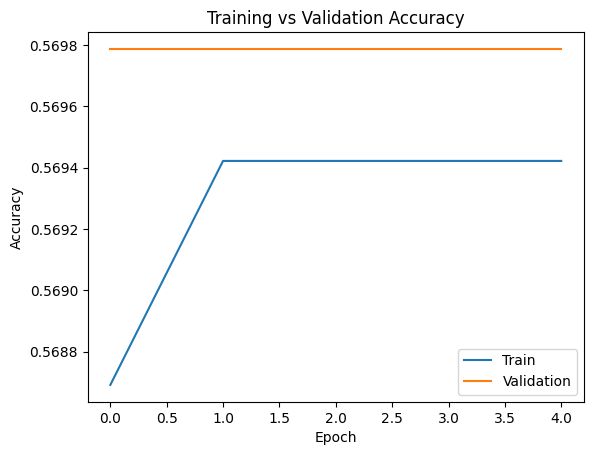

In [8]:
loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
print("LSTM Model Accuracy:", accuracy)

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [11]:
# For the Kaggle Submission
test_df = pd.read_csv('test.csv')
test_ids = test_df['id']
test_df['clean_text'] = test_df['text'].apply(clean_text)

X_test_tfidf = vectorizer.transform(test_df['clean_text'])

lr_test_preds = lr.predict(X_test_tfidf)

submission = pd.DataFrame({
    'id': test_ids,
    'target': lr_test_preds
})

submission.to_csv('submission.csv', index=False)

### Results & Analysis
The baseline models used TF-IDF to convert the cleaned tweets into a representation. The Logistic Regression classifier trained on that representation reached an accuracy of about 77.2% on the test set. This shows that the model was able to distinguish relatively well between which tweets that refered to real disasters vs tweets that didn't. In contrast, the the Long Short Term Memory model, trained over five epochs reached a validation performance of about 56.7%. The training accuracy increased accross the epochs as the model was being trained, but it didn't increase by a significant amount. This score suggests that the model was underfitting. 

### Conclusion
In this project, I explored two different modeling approaches for classifying disaster related tweets, a TF-IDF with Logistic Regression to serve as a baseline model and a sequential deep learning model using an LSTM network. The baseline model performed significantly better than the LSTM, reaching an accuracy of about 77.2%, meanwhile the LSTM model reached an accuracy of 56.7%. These results were very surprising and go to show that complexity does not automatically equal better performance. 

Looking forward, process improvements can be implement to more accurately classify tweets. Some process improvements include adding dropout layers to help the neural network generalize better and trying out different architectures like GRUs. Also, data quality can be improved by adding more features to the dataset. I enjoyed this project and look forward to learn about more architectures in the following course lectures. 